In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from backtest_functions_v2 import *

### strategy baseline: take simple mean of all 6 absa column

In [2]:
df_news = pd.read_parquet('../data/PROD_cryptonews_absa_daily.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [3]:
df.describe()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
count,1461.000000,1438.000000,1421.000000,1425.000000,1427.000000,1438.000000,1202.000000,1461.000000
mean,106.341547,0.204244,-0.067238,-0.012217,0.478250,0.510591,-0.417578,0.001345
std,56.654991,0.298990,0.253940,0.306260,0.199329,0.158141,0.388851,0.032901
min,18.000000,-0.760000,-0.850000,-1.000000,-0.550000,-0.166667,-1.000000,-0.154932
25%,65.000000,0.004545,-0.250000,-0.225000,0.377350,0.427068,-0.700000,-0.013384
50%,98.000000,0.229615,-0.077778,0.000000,0.500000,0.534783,-0.500000,0.000521
75%,132.000000,0.436364,0.111765,0.217857,0.612500,0.620000,-0.213542,0.016509
max,378.000000,0.868421,0.700000,0.800000,1.000000,1.000000,1.000000,0.197580


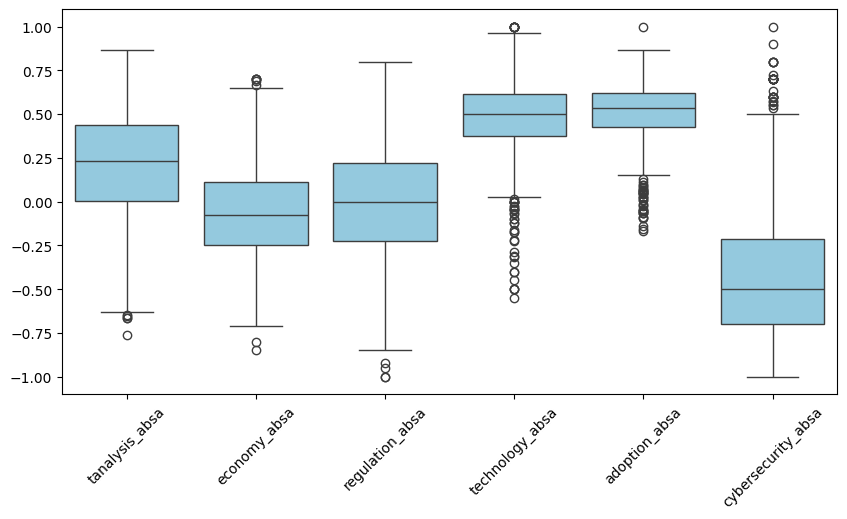

In [4]:
# plot the distribution of the columns
columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[columns], color='skyblue')
plt.xticks(rotation=45)
plt.show()

In [5]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count'], inplace=True)
df.head()

,return_forward,signal
2021-01-01,0.133747,0.223380
2021-01-02,-0.008069,0.325500
2021-01-03,-0.048455,0.408182
2021-01-04,0.073631,0.224037
2021-01-05,0.056172,0.565286


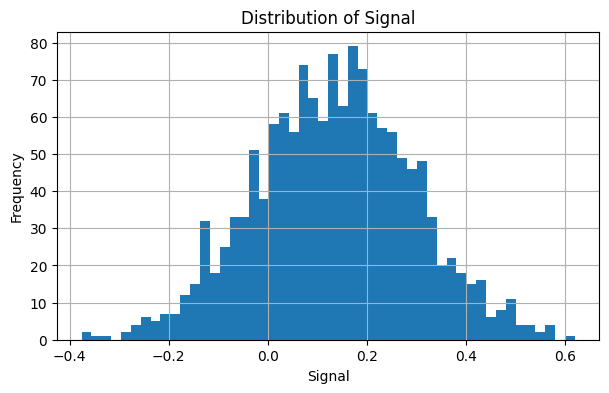

In [6]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Signal smoothing
df['signal'] = df['signal'].ewm(span=3).mean()
# df['signal'] = df['signal'].rolling(window=3).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

Overall Annual Return: 49.33%
Overall Annual Sharpe Ratio: 2.2961
Maximum Drawdown: -9.68 %
Alpha: 0.2117
Beta: 0.2468

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.493275    0.181838     0.246839      0.192059       2.296114


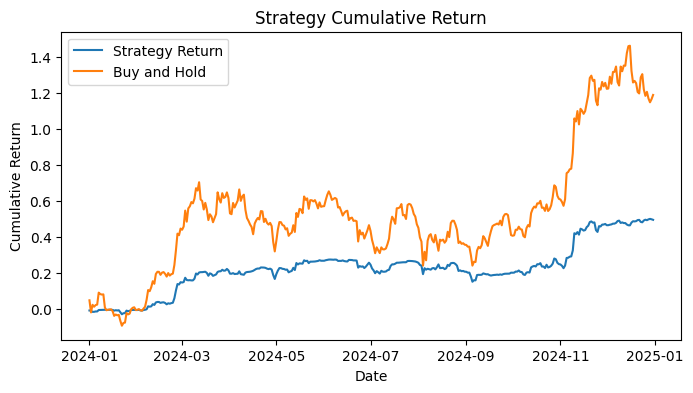

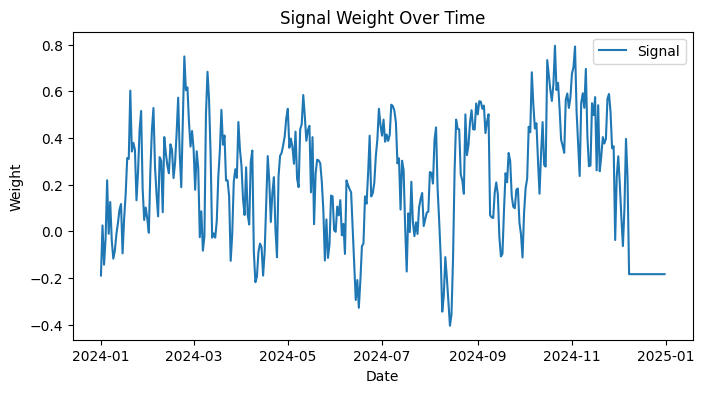

In [8]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)

Overall Annual Return: 115.86%
Overall Annual Sharpe Ratio: 2.2961
Maximum Drawdown: -19.09 %
Alpha: 0.468
Beta: 0.4937

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.158621    0.363677     0.493679      0.384118       2.296114


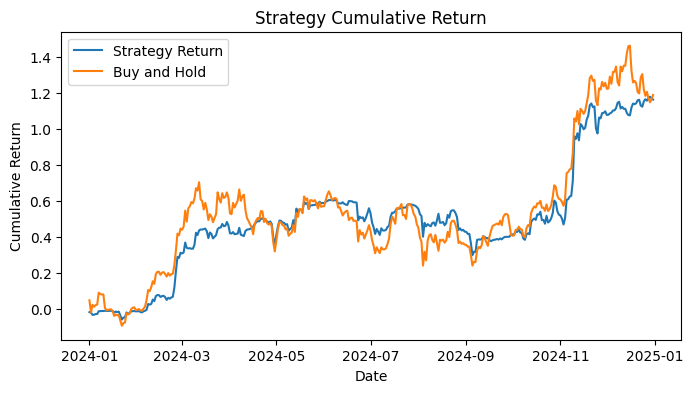

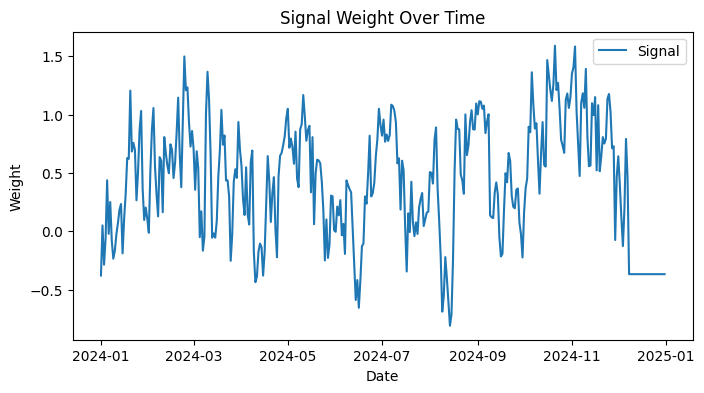

In [9]:
# backtest 2024 only
df = df[df.index.year == 2024]

df['signal'] = df['signal'] * 2

run_backtest(df)

### investigate each feature

In [10]:
df_news = pd.read_parquet('../data/PROD_cryptonews_absa_daily.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [11]:
df.columns

Index(['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa',
       'return_forward'],
      dtype='object')

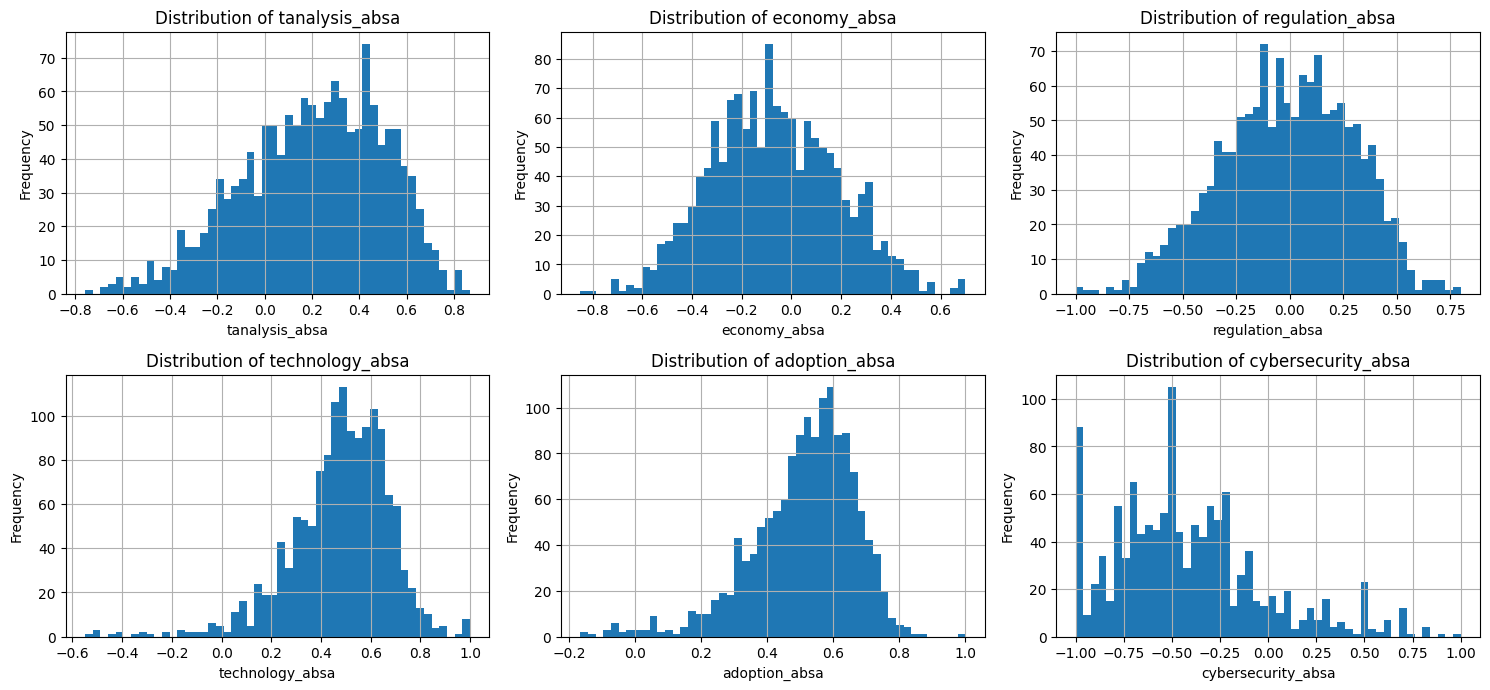

In [12]:
# plot the distribution of the columns
# columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
#        'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'return_forward']

columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
  df[column].hist(ax=axes[i], bins=50)
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

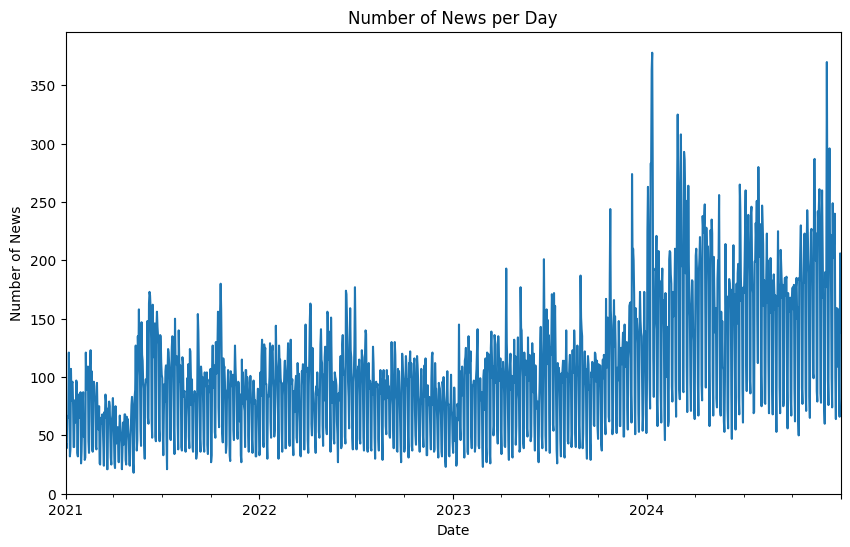

In [13]:
df['news_count'].plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of News')
plt.title('Number of News per Day')
plt.show()

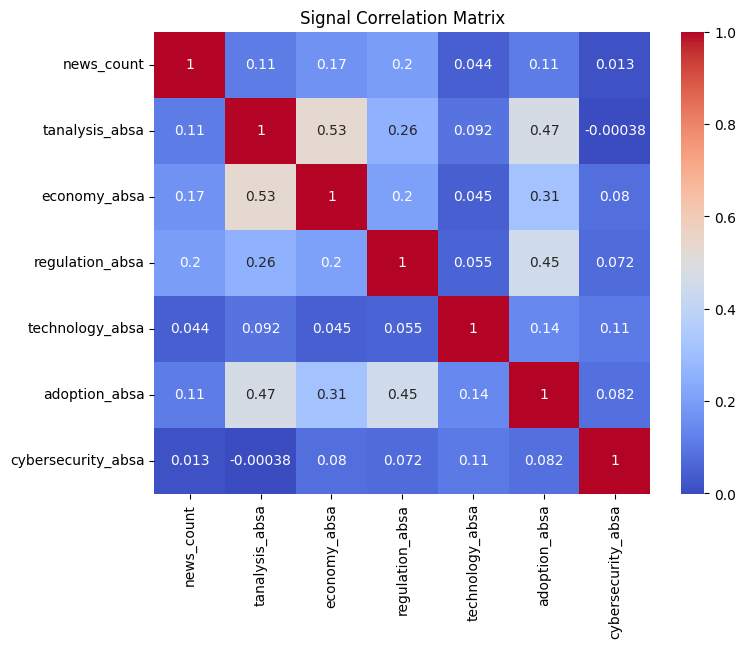

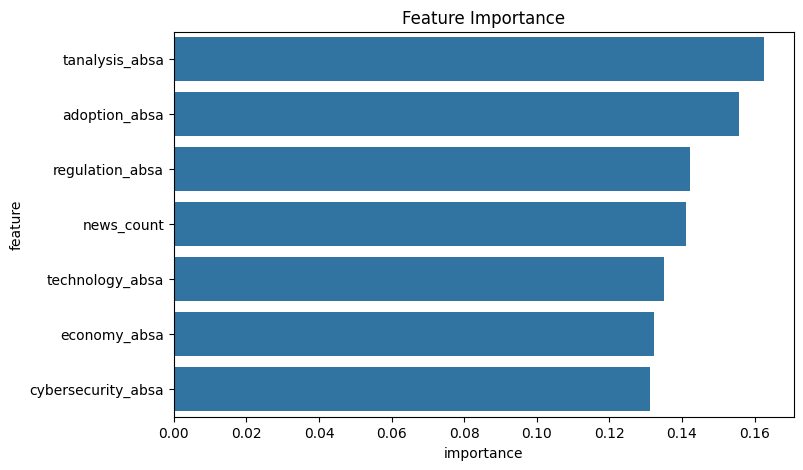


Statistical Analysis:
              feature    f_score       p_value
1      tanalysis_absa  33.855785  7.283823e-09
5       adoption_absa  13.714030  2.207928e-04
2        economy_absa   9.886018  1.698963e-03
4     technology_absa   5.296240  2.151187e-02
3     regulation_absa   0.361276  5.478920e-01
0          news_count   0.146762  7.017049e-01
6  cybersecurity_absa   0.113358  7.364020e-01


In [14]:
def analyze_features(df, signal_columns):
  # 1. Correlation Analysis
  correlation_matrix = df[signal_columns].corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Signal Correlation Matrix')
  plt.show()
  
  # 2. Feature Importance using Random Forest
  X = df[signal_columns].fillna(method='ffill').fillna(method='bfill') # Forward fill then backward fill
  y = df['return_forward']
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X, y)
  
  importance_df = pd.DataFrame({
      'feature': signal_columns,
      'importance': rf.feature_importances_
  }).sort_values('importance', ascending=False)
  
  plt.figure(figsize=(8, 5))
  sns.barplot(data=importance_df, x='importance', y='feature')
  plt.title('Feature Importance')
  plt.show()
  
  # 3. Statistical Analysis
  f_scores, p_values = f_regression(X, y)
  stats_df = pd.DataFrame({
    'feature': signal_columns,
    'f_score': f_scores,
    'p_value': p_values
  }).sort_values('f_score', ascending=False)
  
  print("\nStatistical Analysis:")
  print(stats_df)
  
  return correlation_matrix, importance_df, stats_df

signal_columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
corr_matrix, importance, stats = analyze_features(df, signal_columns)

In [15]:
df = df[df.index.year == 2024]

Overall Annual Return: 46.6%
Overall Annual Sharpe Ratio: 1.7822
Maximum Drawdown: -19.0 %
Alpha: 0.3384
Beta: 0.1283

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.465956    0.229368     0.128266      0.291617        1.78218


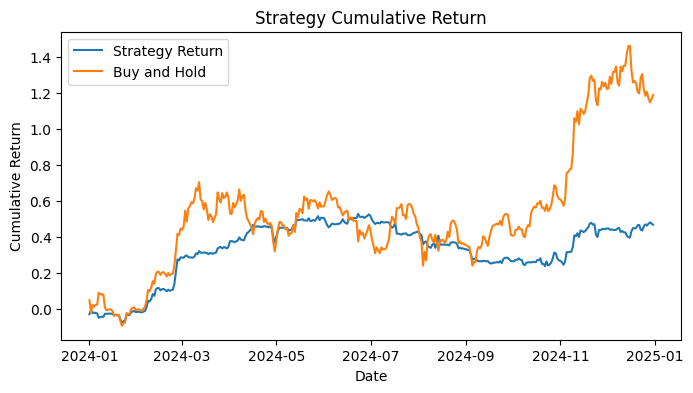

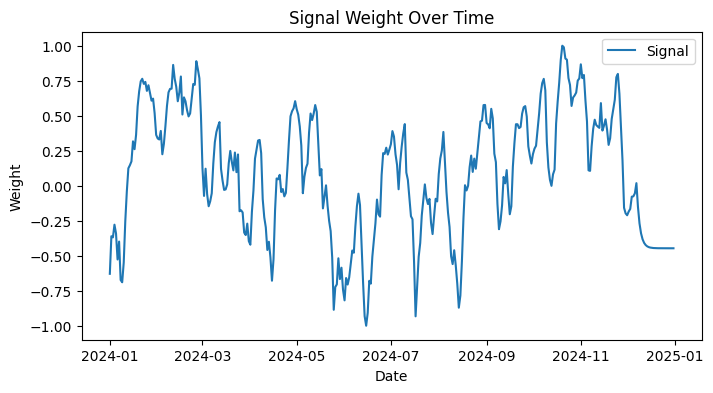

In [16]:
# backtest tanalysis_absa as signal
df['signal'] = df['tanalysis_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=4).mean() # 4 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 62.27%
Overall Annual Sharpe Ratio: 1.6554
Maximum Drawdown: -19.89 %
Alpha: 0.0179
Beta: 0.5679

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.622708    0.324068     0.567947      0.017694        1.65538


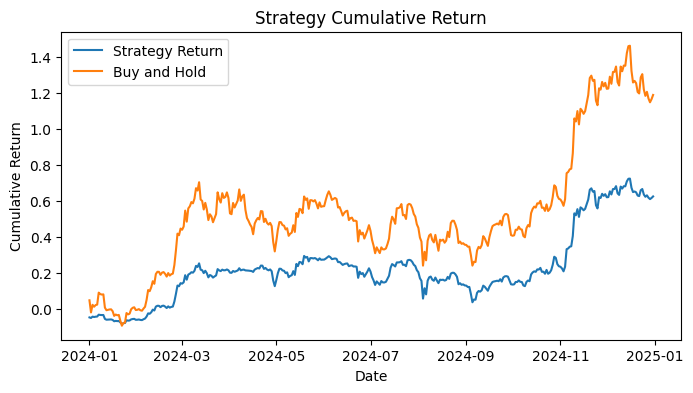

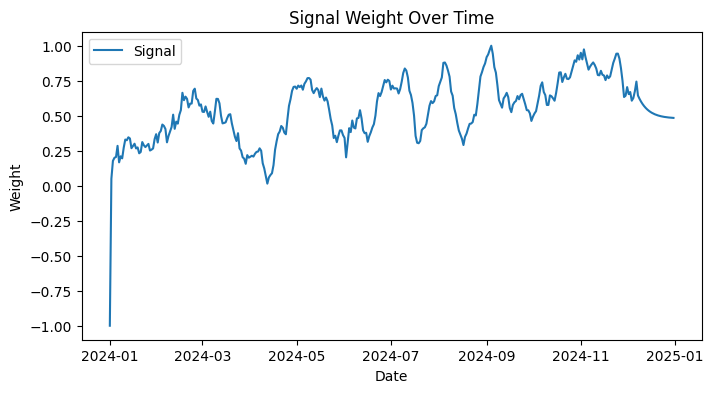

In [17]:
# backtest economy_absa as signal
df['signal'] = df['economy_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=13).mean() # 13 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 36.18%
Overall Annual Sharpe Ratio: 1.6427
Maximum Drawdown: -10.61 %
Alpha: 0.2923
Beta: 0.0792

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.361841    0.200155     0.079155      0.256486       1.642657


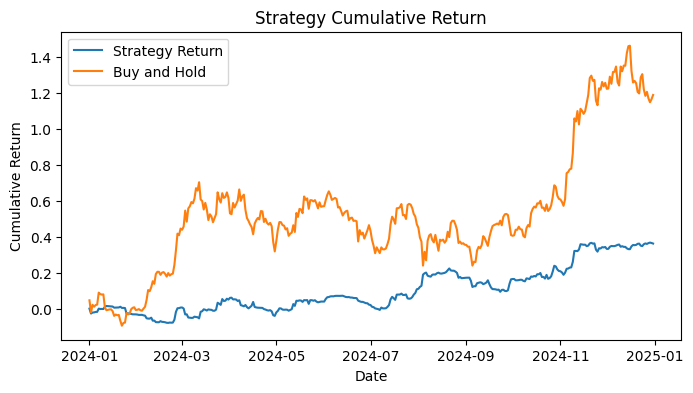

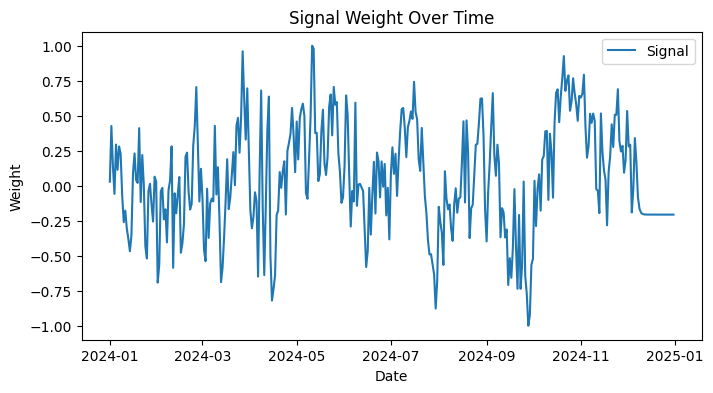

In [18]:
# backtest regulation_absa as signal
df['signal'] = df['regulation_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=2).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 68.51%
Overall Annual Sharpe Ratio: 2.3717
Maximum Drawdown: -12.94 %
Alpha: 0.3005
Beta: 0.3133

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.685148    0.231461     0.313251      0.262825       2.371662


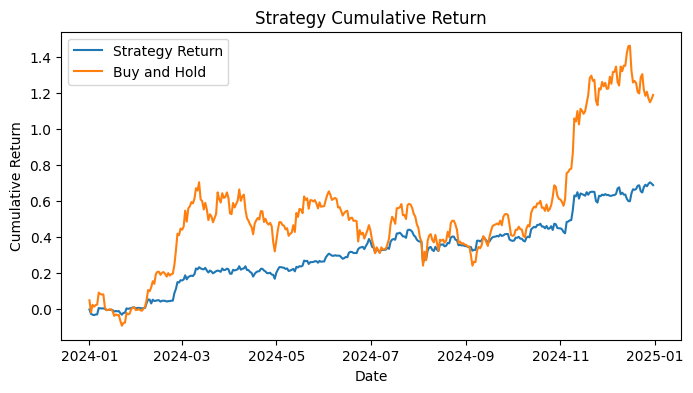

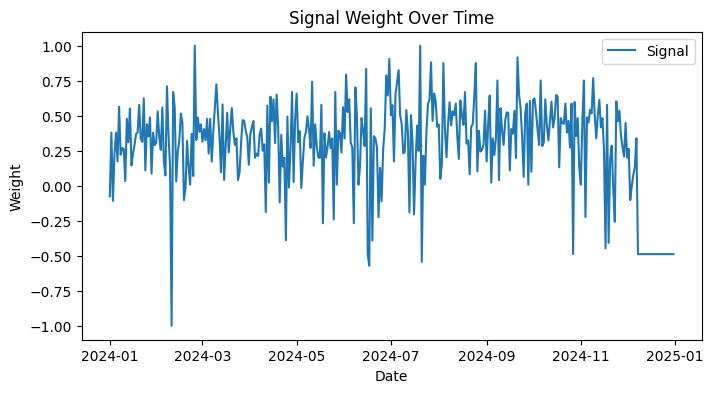

In [19]:
# backtest technology_absa as signal
df['signal'] = df['technology_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 76.06%
Overall Annual Sharpe Ratio: 1.9684
Maximum Drawdown: -20.5 %
Alpha: 0.2057
Beta: 0.4677

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.760642    0.312075     0.467717      0.187085       1.968425


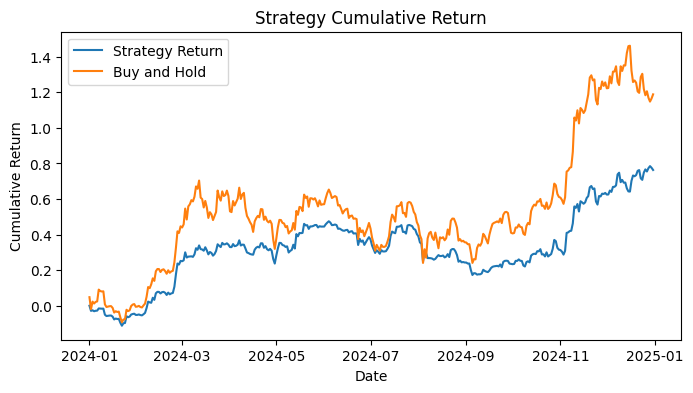

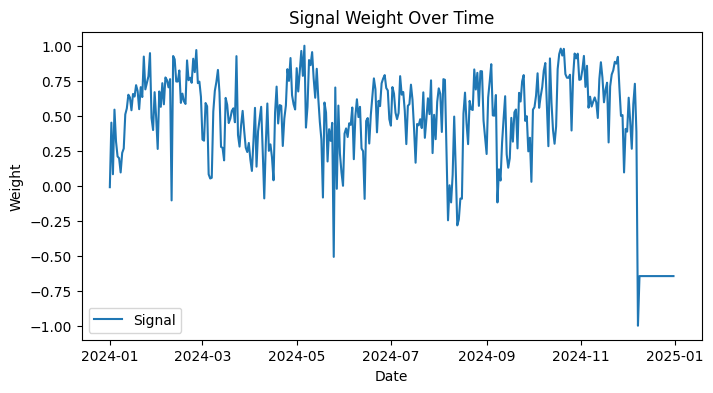

In [20]:
# backtest adoption_absa as signal
df['signal'] = df['adoption_absa']
df['signal'] = df['signal'].fillna(0)

# no smmothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: -23.32%
Overall Annual Sharpe Ratio: -0.9446
Maximum Drawdown: -32.52 %
Alpha: -0.0227
Beta: -0.2315

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.233234     0.24818    -0.231522     -0.022966       -0.94463


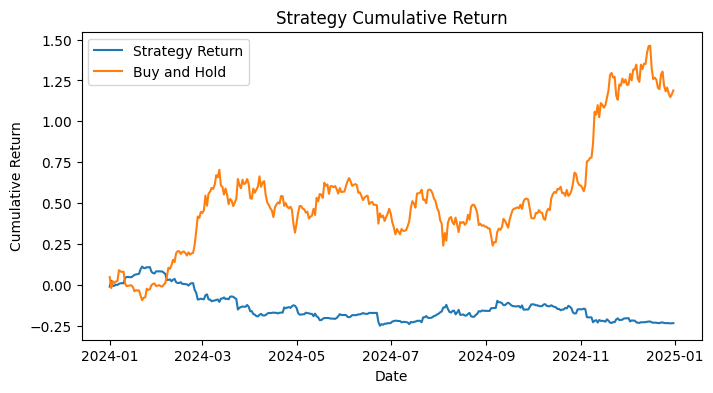

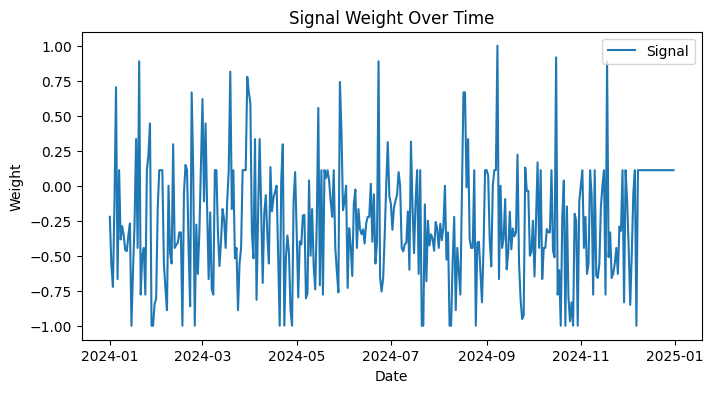

In [21]:
# backtest cybersecurity_absa as signal
df['signal'] = df['cybersecurity_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

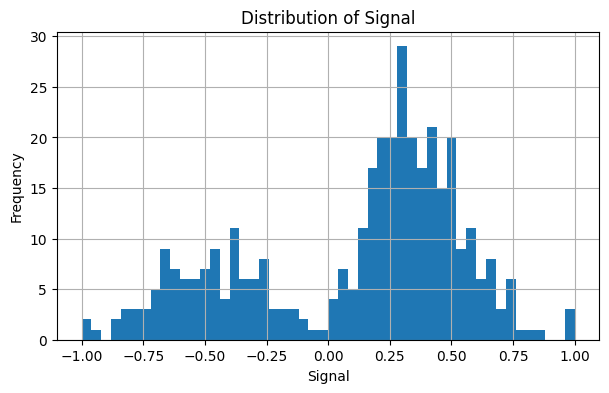

Overall Annual Return: -3.94%
Overall Annual Sharpe Ratio: -0.0327
Maximum Drawdown: -28.43 %
Alpha: -0.1114
Beta: 0.1202

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.039449    0.253081     0.120169     -0.118047      -0.032737


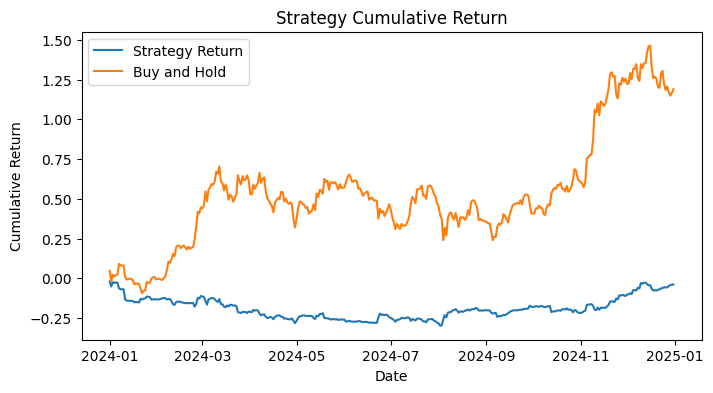

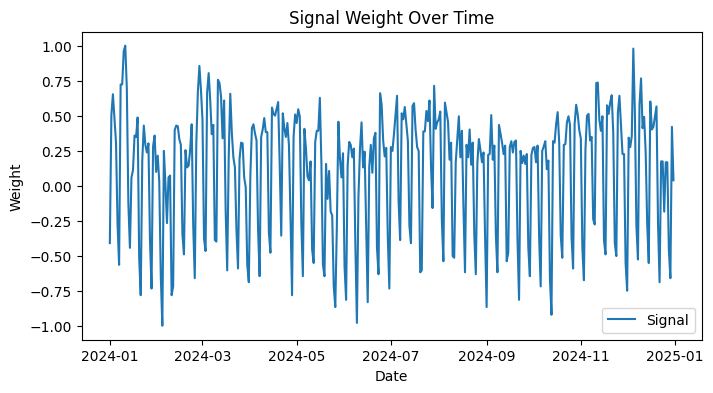

In [22]:
# backtest news_count as signal
df['signal'] = df['news_count']
df['signal'] = df['signal'].fillna(0)

# feature scaling, right skewed, log transformation
df['signal'] = np.log1p(df['signal'])

# scale the signal to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

# plot the distribution of the signal
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

run_backtest(df)


### strategy: simple mean of 5 absa cols

In [23]:
df_news = pd.read_parquet('../data/PROD_cryptonews_absa_daily.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [24]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)
df.head()

,return_forward,signal
2021-01-01,0.133747,0.328056
2021-01-02,-0.008069,0.325500
2021-01-03,-0.048455,0.408182
2021-01-04,0.073631,0.224037
2021-01-05,0.056172,0.565286


In [25]:
df = df.fillna(0)

# apply ewm
df['signal'] = df['signal'].ewm(span=4).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

Overall Annual Return: 67.63%
Overall Annual Sharpe Ratio: 2.2889
Maximum Drawdown: -13.77 %
Alpha: 0.2765
Beta: 0.3293

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.676341    0.238088     0.329303      0.244175       2.288897


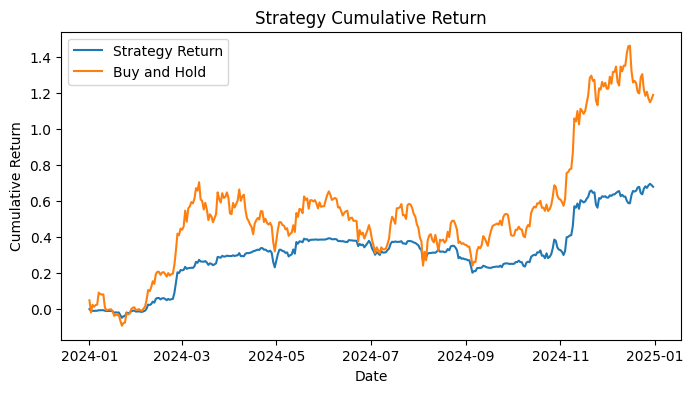

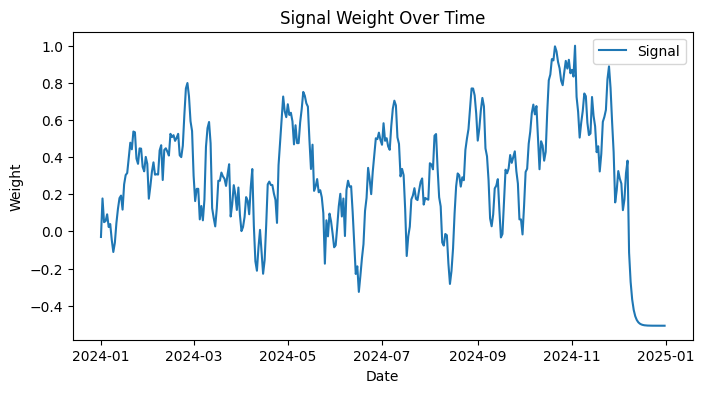

In [26]:
df = df[df.index.year == 2024]

run_backtest(df)

Overall Annual Return: 165.82%
Overall Annual Sharpe Ratio: 2.2889
Maximum Drawdown: -26.49 %
Alpha: 0.6291
Beta: 0.6586

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        1.65824    0.476177     0.658606      0.488351       2.288897


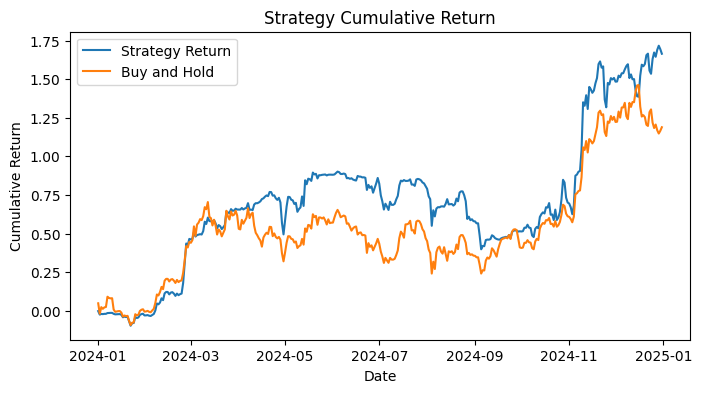

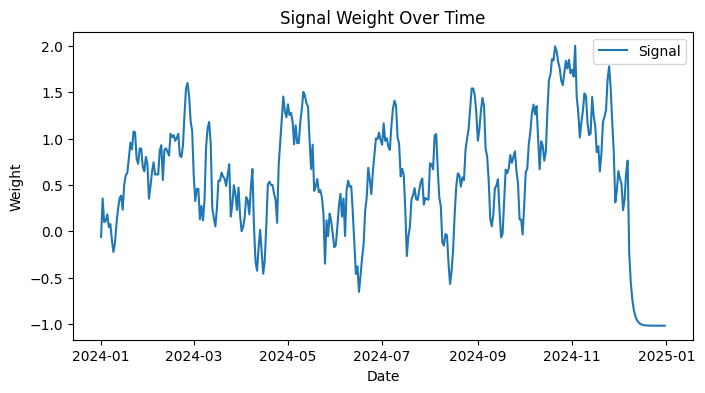

In [27]:
df['signal'] = df['signal'] * 2
run_backtest(df)

Overall Annual Return: 118.43%
Overall Annual Sharpe Ratio: 1.7741
Maximum Drawdown: -27.2 %
Alpha: 0.0
Beta: 1.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.184281     0.51485          1.0           0.0       1.774104


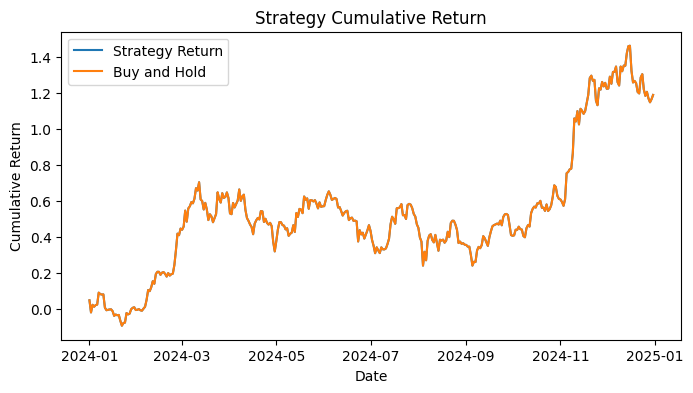

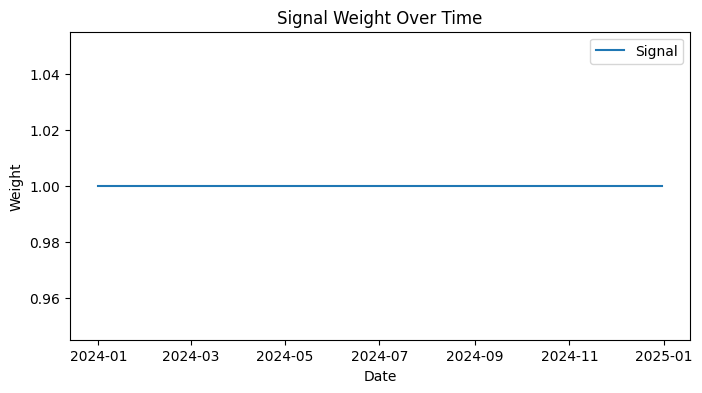

In [28]:
df['signal'] = 1

run_backtest(df)

### reduce trading fee: less frequent trades

In [29]:
df_news = pd.read_parquet('../data/PROD_cryptonews_absa_daily.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [30]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']
df['mean_sentiment'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)
df.head()

,return_forward,mean_sentiment
2021-01-01,0.133747,0.328056
2021-01-02,-0.008069,0.325500
2021-01-03,-0.048455,0.408182
2021-01-04,0.073631,0.224037
2021-01-05,0.056172,0.565286


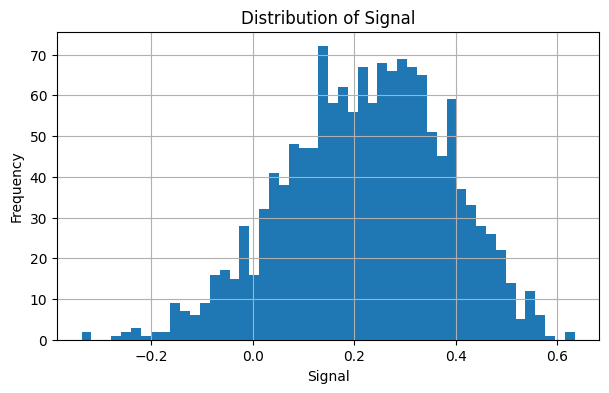

In [31]:
df['mean_sentiment'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Signal smoothing
df['mean_sentiment'] = df['mean_sentiment'].ewm(span=3).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['mean_sentiment'] = scaler.fit_transform(df['mean_sentiment'].values.reshape(-1, 1))

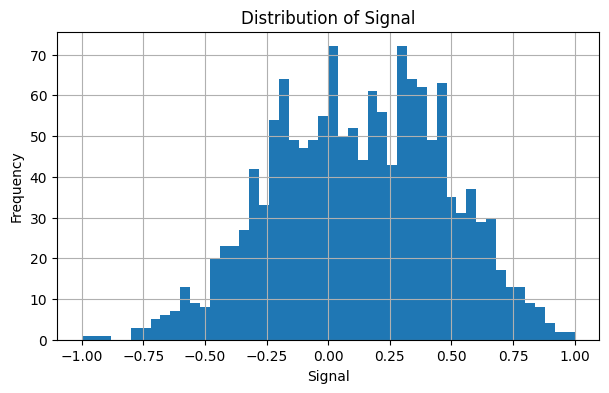

In [33]:
df['mean_sentiment'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [34]:
df['signal'] = 0
# df['signal'] = np.where(df['mean_sentiment'] > 0.1, 0.5, df['signal'])
# df['signal'] = np.where(df['mean_sentiment'] > 0.3, 1, df['signal'])

df['signal'] = np.where(df['mean_sentiment'] > 0.15, 1, df['signal'])

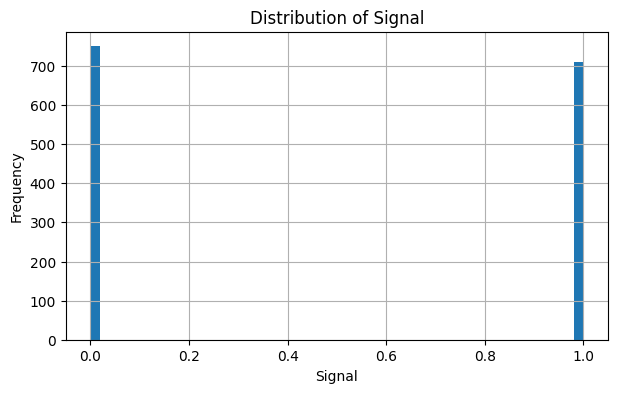

In [35]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

Overall Annual Return: 115.45%
Overall Annual Sharpe Ratio: 2.1142
Maximum Drawdown: -28.97 %
Alpha: 0.9085
Beta: 0.409

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       3.944072    0.535516     0.407582      1.397873       3.254363
1  2022      -0.069114    0.242826     0.155213      0.091027      -0.175188
2  2023       0.947978    0.321033     0.467881      0.220514       2.237369
3  2024       1.402543    0.437086     0.721322      0.313162       2.223852


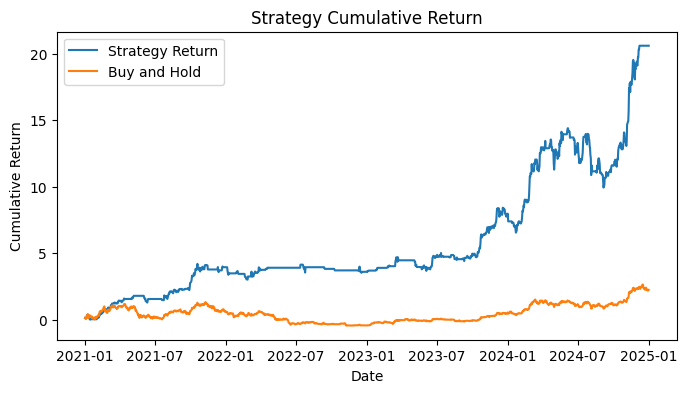

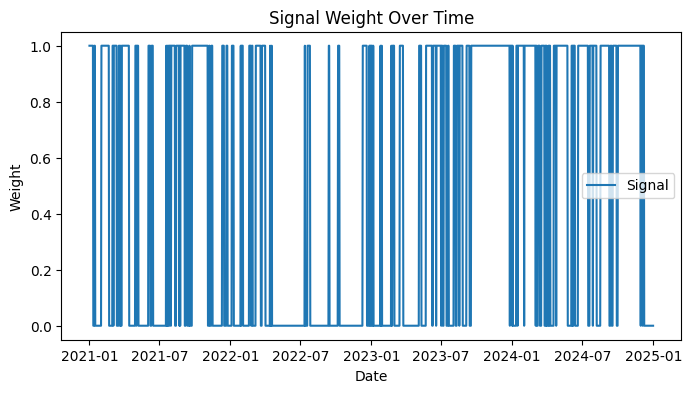

In [36]:
run_backtest(df)

Overall Annual Return: 140.25%
Overall Annual Sharpe Ratio: 2.2239
Maximum Drawdown: -28.97 %
Alpha: 0.3676
Beta: 0.7213

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.402543    0.437086     0.721322      0.313162       2.223852


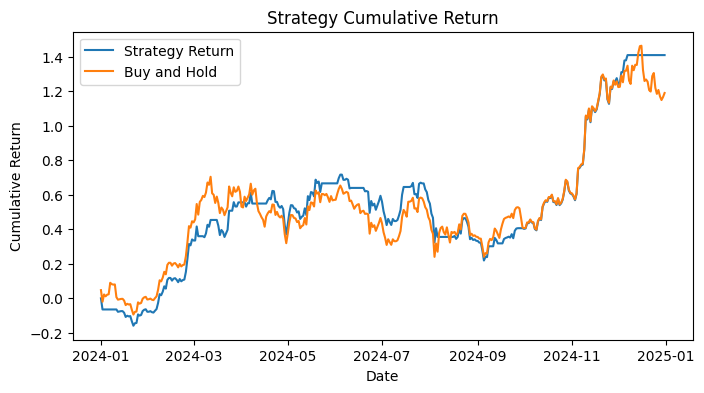

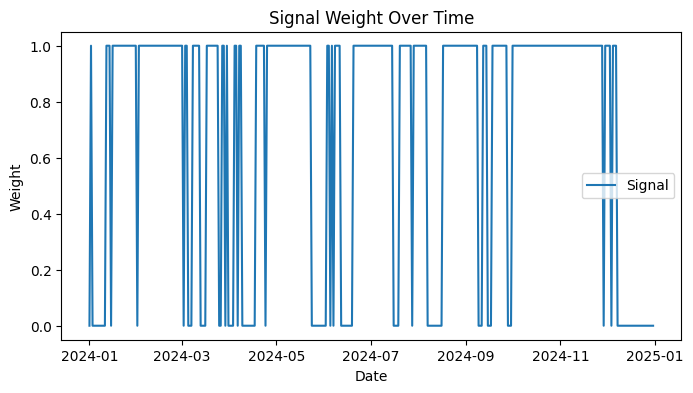

In [37]:
# backtest 2024 only
df = df[df.index.year == 2024]

# df['signal'] = df['signal']

run_backtest(df)